## Importing Dependencies

In [28]:
import numpy as np
import cv2

import os
import tensorflow as tf

import matplotlib.pylab as plt

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading Image Dataset

In [30]:
data_dir = 'imgdata_v3'

In [31]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))

Found 7437 files belonging to 2 classes.


In [32]:
batch = dataset.as_numpy_iterator().next()
len(batch)

2

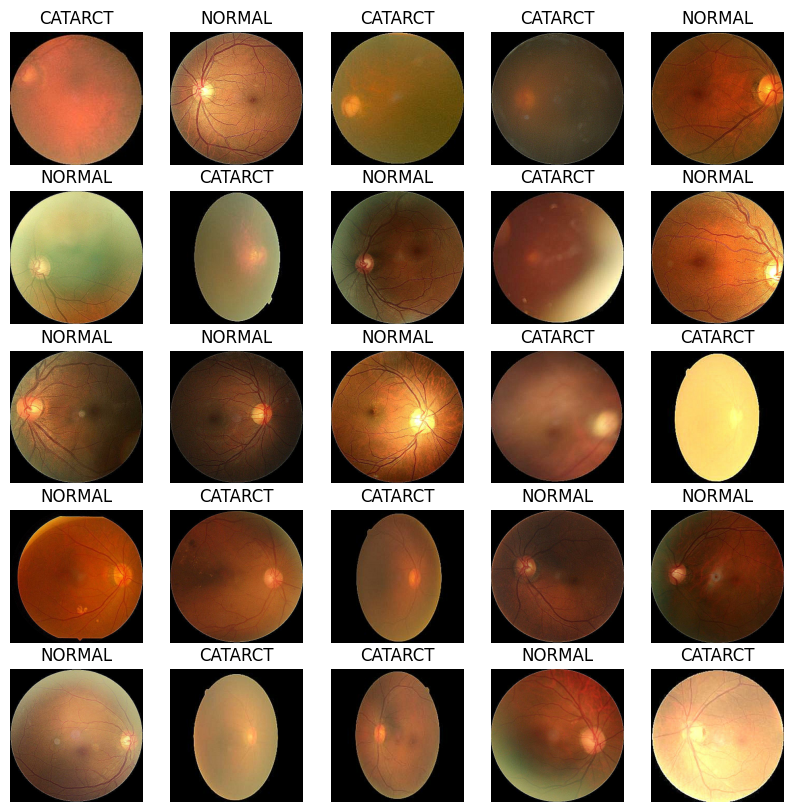

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for idx, img in enumerate(batch[0][:25]):
    row = idx//5
    col = idx%5
    
    axs[row, col].imshow(img.astype(int))
    axs[row, col].axis('off')
    axs[row, col].set_title('CATARCT' if batch[1][idx]==0 else 'NORMAL')

## Scaling Dataset

In [34]:
batch[0][0].shape, batch[0][0].max(), batch[0][0].min()

((256, 256, 3), 255.0, 0.0)

In [35]:
data = dataset.map(lambda x, y: (x/255, y))

In [36]:
print(data.as_numpy_iterator().next()[0][0].shape,
    data.as_numpy_iterator().next()[0][0].max(),
    data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3) 0.99313724 0.0


## Splitting Dataset

In [37]:
len(data)

233

In [38]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)

train_size + val_size + test_size

233

In [39]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

Inception ResNet Model

In [52]:
import tensorflow as tf
from keras import Sequential,Model,models
from keras.layers import Dense,Dropout,Flatten,BatchNormalization, Conv2D, MaxPooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2 , preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

In [53]:
inception_arch=InceptionResNetV2(input_shape=[256, 256] + [3],weights="imagenet",include_top=False)

In [54]:
for layer in inception_arch.layers:
    layer.trainaable = False

In [55]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_regularizer=l2(0.001), activation='sigmoid'))

model.compile(optimizer='adam', loss='hinge', metrics='accuracy')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1019 (Conv2D)        (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_1020 (Conv2D)        (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 62, 62, 32)       

In [56]:
model.compile(optimizer="adam",loss="mse",metrics=['accuracy'])

In [57]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [66]:
model_fit = model.fit(train_data, 
                       epochs=10, 
                       shuffle=True, 
                       validation_data=val_data)
                       #callbacks=[tfb_callback])

Epoch 1/10
163/163 [==============================] - 125s 763ms/step - loss: 0.0813 - accuracy: 0.8934 - val_loss: 0.0751 - val_accuracy: 0.8989
Epoch 2/10
163/163 [==============================] - 125s 764ms/step - loss: 0.0722 - accuracy: 0.9022 - val_loss: 0.0947 - val_accuracy: 0.8737
Epoch 3/10
163/163 [==============================] - 126s 769ms/step - loss: 0.0675 - accuracy: 0.9099 - val_loss: 0.0717 - val_accuracy: 0.9142
Epoch 4/10
163/163 [==============================] - 126s 774ms/step - loss: 0.0613 - accuracy: 0.9193 - val_loss: 0.0640 - val_accuracy: 0.9142
Epoch 5/10
163/163 [==============================] - 126s 771ms/step - loss: 0.0615 - accuracy: 0.9170 - val_loss: 0.0927 - val_accuracy: 0.8943
Epoch 6/10
163/163 [==============================] - 127s 777ms/step - loss: 0.0593 - accuracy: 0.9210 - val_loss: 0.0548 - val_accuracy: 0.9335
Epoch 7/10
163/163 [==============================] - 127s 779ms/step - loss: 0.0549 - accuracy: 0.9248 - val_loss: 0.0587 -

## Model Performance 

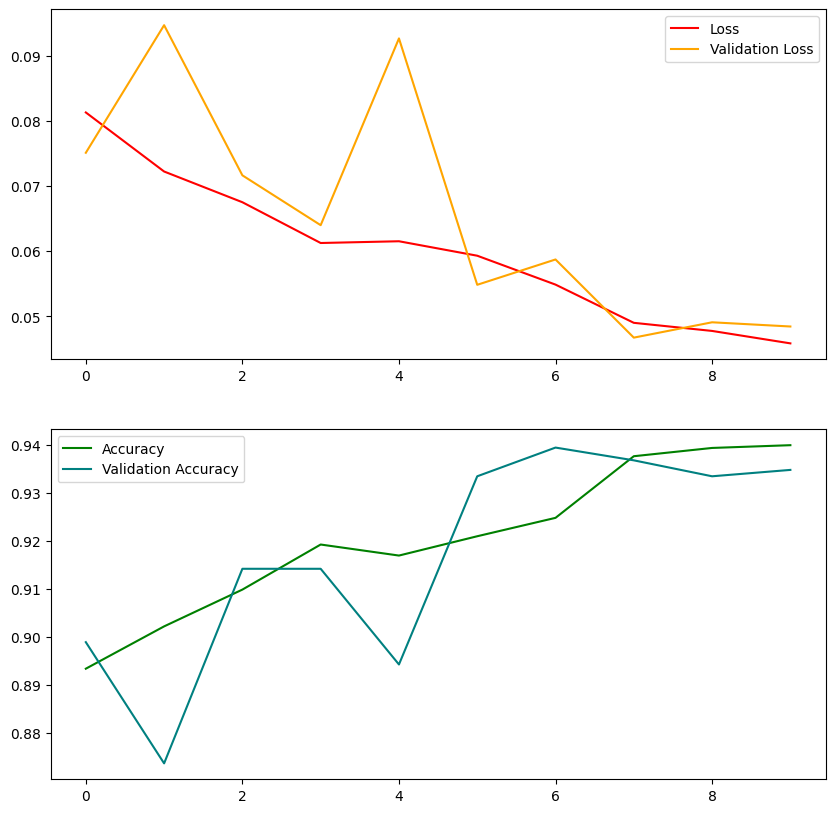

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(model_fit.history['loss'], color='red', label='Loss')
axs[0].plot(model_fit.history['val_loss'], color='orange', label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

## Evaluating Model

In [70]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()

In [71]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    rec.update_state(y, y_pred)

print('Accuracy: ', acc.result().numpy())
print('Precision: ', pre.result().numpy())
print('Recall: ', rec.result().numpy())


KeyboardInterrupt



## Exporting Model

In [73]:
model.save(os.path.join('models', 'ODIR_INCEPTION.h5'))

In [74]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join('models', 'ODIR_INCEPTION.h5'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1019 (Conv2D)        (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_1020 (Conv2D)        (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 62, 62, 32)       